Multi-Layer Perceptron
===
MLP from scratch using numpy (classic Matrix implementation) and JAX (automatic differentiation). Here i have to a code example of Multi-Layer Perceptron as Convolutional Kernel

Imports

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles 
import pandas as pd
import jax.numpy as jnp
import jax 
from sklearn.metrics import confusion_matrix
import jax.numpy as jnp
from jax import grad
from jax import random
from functools import partial
from jax import jit

Create a dataset to work for now

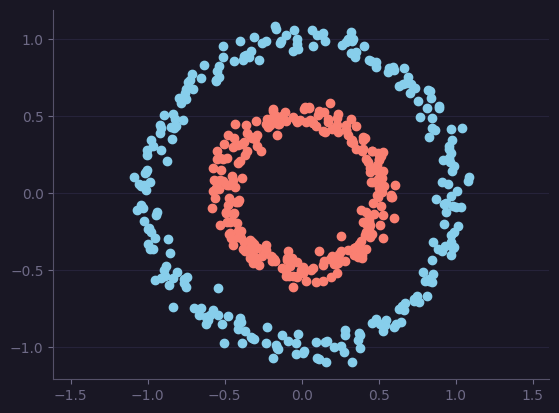

In [7]:
#CREAR el data set 
n = 500   #este es el numero de set
p = 2     #number of features that we have
X, Y =make_circles(n_samples=n, factor=0.5,noise=0.05)  #to create the data set in a circle
#X=X/3+0.5 #para normalizar los datos
Y=Y[:,np.newaxis]

# esto nos diría si un punto pertenece a un circulo u otro con 0 y 1
plt.style.use('rose-pine')
plt.scatter(X[Y[:,0]==0,0],X[Y[:,0]==0,1], c="skyblue")
plt.scatter(X[Y[:,0]==1,0],X[Y[:,0]==1,1],c="salmon")
plt.axis("equal")
plt.show()


One hot encoding for labels

In [8]:
def one_hot_encode(df):
    Hot_df=pd.DataFrame()
    for i in range(df.shape[1]):
        df_column=df.iloc[:,i]
        Numero_clases_diferentes=df_column.unique().shape[0]
        numero_elementos=df_column.shape[0]
        clases_diferentes=df_column.unique().reshape((Numero_clases_diferentes,1))
        array_datos_clases=np.zeros(shape=(numero_elementos,Numero_clases_diferentes))
        iterador_clases=0
        for titles in clases_diferentes:
            for elemento in range(numero_elementos):
                clase=df_column.iloc[elemento]
                if clase==titles:
                    array_datos_clases[elemento,iterador_clases]=1            
            iterador_clases +=1
        df_HotEncoding=pd.DataFrame(array_datos_clases,
                        columns=clases_diferentes.astype(str))
        Hot_df=pd.concat([Hot_df, df_HotEncoding], axis=1)
    return Hot_df

In [9]:
#apply one hot encode to Y 
Y_sinhot=Y
df = pd.DataFrame(Y, columns=['clases'])
Y=one_hot_encode(df)
Y.shape
#convert to numpy array
Y=Y.to_numpy()
X.shape

(500, 2)

create a class to initialize and save w,b y f values per layer

In [10]:
class neural_layer():
    '''
    A class to represent a neural layer
    args:
        n_conn: number of connections to the next layer
        n_neur: number of neurons in the layer
        act_f: activation function
    '''
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f = act_f  #for activation function

        '''create a vector with inicialized random values'''
        self.b = np.random.rand(1, n_neur) * 2 - 1 
        self.W = np.random.rand(n_conn, n_neur) * 2 - 1

Defining some activations functions

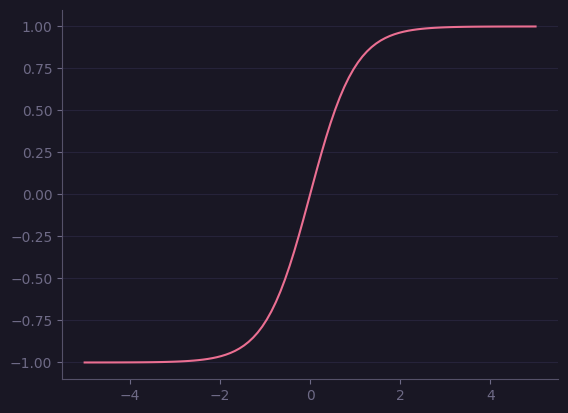

In [11]:
#activation functions (we are going to use the tanh)
sigm=(lambda x: 1/(1+ np.e**(-x)),lambda x: x*(1-x))

tanh=(lambda x: np.tanh(x),lambda x: 1-np.tanh(x)**2) # activation function and its derivative
_x=np.linspace(-5,5,100)
plt.plot(_x,tanh[0](_x))

Function to create a network using a specific topology

In [12]:
#l0= neural_layer(p,4,sigm)
#l1= neural_layer (4,8,sigm)
# ... we could create the layers like this but we are going to do it in a more elegant way

topology=[2,4,2]  #or [len de parametros iniciales,4 neuronas en capa oculta,clases]
def create_nn(topology, act_f):
  nn= [] 
  for l, layer in enumerate(topology[:- 1]):
    nn.append(neural_layer(topology[l], topology[l+1], act_f))  # generamos una a una las capas de la red iniciando clase con (numero de conexiones, numero de neuronas, funcion de activacion)
  return nn

Some metrics:

In [13]:
l2_cost = (lambda soft, Yi: np.mean(-Yi*np.log(soft)),    #es la funcion de coste  de cross entropy
           lambda soft, Yi:(soft-Yi))           #es la derivada de la funcion de coste de cross entropy (en el caso de Y labels con one hoy encoding, sino usar:soft*y_i-y_i)

def get_predictions(A2):
    return np.argmax(A2,axis=1)

def get_accuracy(predictions, Y_sinhot):

    return np.sum(predictions == Y_sinhot) / Y_sinhot.size

def recall_2clases(y_sinhot, y_hat):
    """
    recall
    args:
        y_sinhot: Real Labels
        y_hat: estimated labels
    return TP/(TP+FN)
    """
    TP=0
    FN=0
    for i in range(len(y_sinhot)):
        if (y_sinhot[i]>0 and y_hat[i]>0):
            TP += 1
        if (y_sinhot[i]<=0 and y_hat[i]>0):
            FN +=1
    recall = (TP/(TP+FN))
    return float(recall)

def recall(y_sinhot, y_hat,return_TP_FN=False):
    """
    recall
    args:
        y_sinhot: Real Labels
        y_hat: estimated labels
    return TP/(TP+FN)
    """
    TP=0
    FN=0
    unique=np.unique(y_hat)
    recalls=[]
    for clase in range(len(unique)):
        for muestra in range(len(y_sinhot)):
            if (y_sinhot[muestra]==clase and y_hat[muestra]==clase):
                TP += 1
            if (y_sinhot[muestra]==clase and y_hat[muestra]!=clase):
                FN +=1
        recalls.append(TP/(TP+FN))

    mean_recall=np.mean(recalls) 
    #print("Recall: ", mean_recall)
    if return_TP_FN:
        return mean_recall,TP,FN
    else:
        return mean_recall
        

def precision( y_sinhot, y_hat,return_TP_FP=False):
    """
    precision                           
    args:
        y_sinhot: Real Labels
        y_hat: estimated labels
    return TP/(TP+FP)
    """
    TP=0
    FP=0

    unique=np.unique(y_hat)
    precisions=[]
    for clase in range(len(unique)):
        for muestra in range(len(y_sinhot)):
            if (y_sinhot[muestra]==clase and y_hat[muestra]==clase):
                TP += 1
            if (y_sinhot[muestra]!=clase and y_hat[muestra]==clase):
                FP +=1
        #para evitar divisiones entre 0
        if (TP+FP)==0:
            precisions.append(0)
        else:
            precisions.append(TP/(TP+FP))
    
    mean_precision=np.mean(precisions)
    if return_TP_FP:
        return mean_precision,TP,FP
    else:
        return mean_precision

Example code using numpy for training the neural network using classic matrix implementation

In [14]:
def train(neural_net, X, Y, l2_cost, lr=0.5, train= True): #aqui pasara todo foward pass, backward pass y decenso del gradiente lr es el learning reate para el decenso del gradiente
  
  samples= len(X) #numero de muestras
  #foward pass----------------------
  def forward(X):
    out = [(None,X)]    #es un vector vacio donde se guardará valores, pero se define el primer elemneto en el que la suma ponderada inicial será cero
    for l , layer in enumerate(neural_net):
      z = out[-1][1] @ neural_net[l].W + neural_net[l].b   # esta es para la suma ponderada usando los numeros aleatorios el @ es para mult de matrices
      if l==len(neural_net)-1:
        a=np.exp(z)/np.sum(np.exp(z),axis=1, keepdims=True) #usaremos softmax para la ultima capa
      else:
        a = np.tanh(z)
      out.append((z, a))  #aqui se guardan los valores de la suma ponderada, la activacion y la funcion softmax
    return out
  out=forward(X)

  if train:
    #Backward pass----------------------
    deltas = []
    deltas_jax=[]
    for l in reversed(range(0, len(neural_net))): # en este caso de topologia [2,4,2] entonces 2,1,0
      z= out[l+1][0]  #le sumamos uno porque el primer elemento es el de la entrada X
      a= out[l+1][1]
      if l == len(neural_net) - 1: #si estamos en la ultima capa
        #calcular delta  ultima capa
        deltas.insert(0, a-Y)
        deltas_jax.insert(0, jnp.array(a-Y))
        #si estuvieramos usando la misma funcion de activacion en la ultima capa y por ejemplo el error cuadratico medio
        #entonces tendriamos que multiplicar por la derivada de la funcion de la funcion de costo por la derivada de la funcion de activacion:
        #deltas.insert(0, l2_cost[1](soft,Y) * neural_net[l].act_f[1](a)) 

      else:
        #calcular delta respecto a capa previa
        deltas.insert(0, deltas[0]@ _W.T * neural_net[l].act_f[1](a))    #esto del insert es porque vamos al revez ahora en vez del append el .T es de transpuesta------
      _W=neural_net[l].W      #esto es para no confundirlo cuando calculamos en dradient descent

      #gradient descent
      neural_net[l].b= neural_net[l].b- np.mean(deltas[0], axis=0, keepdims=True)* lr  #esto es para optimizar coste con parametro de bias
      neural_net[l].W= neural_net[l].W- out[l][1].T @ deltas[0]* lr*(1/samples)
    return out[-1][1]
         
  return out[-1][1]

epoch training code:

In [15]:
def trainig_model(X,Y,Y_sinhot,topology,l2_cost,steps=2000,lr=0.28,threshold=0.0001): #aqui pasara todo foward pass, backward pass y decenso del gradiente lr es el learning reate para el decenso del gradiente
  neural_n = create_nn(topology, tanh)
  precisions=[]
  recalls=[]
  loss=[]
  acuracies=[]
  for i in range (steps):
    salida_ultima_capa=train(neural_n, X, Y, l2_cost, lr)
    loss.append(l2_cost[0](salida_ultima_capa,Y))

    #print cada 100 pasos
    if i%100==0:
      prediccion=get_predictions(salida_ultima_capa)    
      prediccion=np.reshape(prediccion, Y_sinhot.shape)
      acuracies.append(get_accuracy(prediccion,Y_sinhot))
      precisions.append(precision(Y_sinhot,prediccion))
      recalls.append(recall(Y_sinhot,prediccion))
      print('\r' + ' ' * 100, end='\r')
      print('step=',i,'lost: {:.3f},acuracy: {:.3f}, recall: {:.3f}, precisions: {:.3f}'.format(loss[-1],acuracies[-1], recalls[-1], precisions[-1]), end='\r')

    #si la perdida no cambia mucho en 2 pasos, se detiene el entrenamiento
    if i>1:
      if np.abs(loss[-1]-loss[-2])< threshold:
        prediccion=get_predictions(salida_ultima_capa)    
        prediccion=np.reshape(prediccion, Y_sinhot.shape)
        precisions.append(precision(Y_sinhot,prediccion))
        recalls.append(recall(Y_sinhot,prediccion))
        print('\r' + ' ' * 100, end='\r')
        print('step=',i,'lost: {:.3f},acuracy: {:.3f}, recall: {:.3f}, precisions: {:.3f}'.format(loss[-1], acuracies[-1], recalls[-1], precisions[-1]), end='\r')
        break
  return recalls,precisions,loss,prediccion

We run it and look at metrics.
Note: metrics=0 means good prediction (overfiting even )

In [16]:
topology=[2,4,2]
recalls,precisions,loss,last_prediccion=trainig_model(X,Y,Y_sinhot,topology,l2_cost,steps=2000,lr=0.38,threshold=0.00001)

Functions for plotting metrics and confusion matrix:

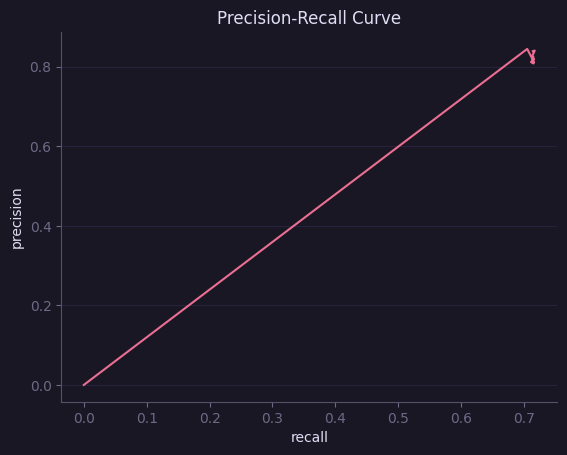

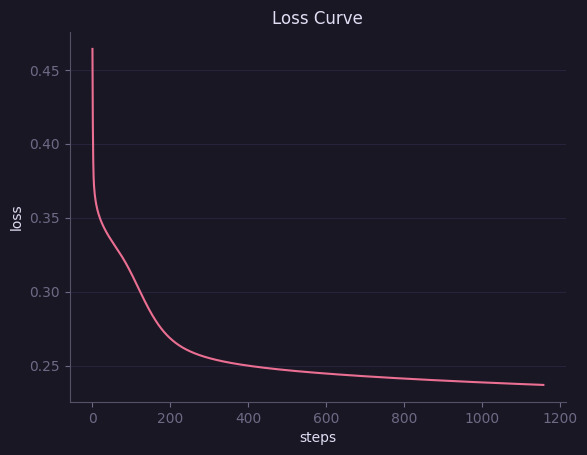

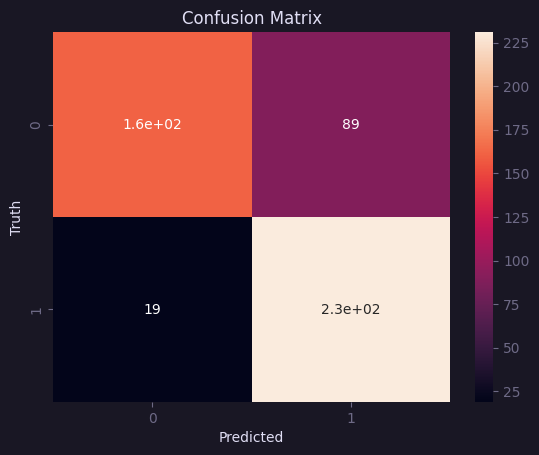

In [17]:
import seaborn as sns
def precision_recall_plot(recalls,precisions):
  plt.style.use('rose-pine')
  plt.plot(recalls,precisions)
  plt.xlabel('recall')
  plt.ylabel('precision')
  plt.title('Precision-Recall Curve')
  plt.show()

def loss_plot(loss):
  plt.plot(loss)
  plt.xlabel('steps')
  plt.ylabel('loss')
  plt.title('Loss Curve')
  plt.show()

def confusion_matrix_plot(Y_sinhot, last_prediccion):
  #confusion matrix
  cm=confusion_matrix(Y_sinhot, last_prediccion)
  sns.heatmap(cm, annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.title('Confusion Matrix')
  plt.show()

precision_recall_plot(recalls,precisions)
loss_plot(loss)
confusion_matrix_plot(Y_sinhot, last_prediccion)

We can see how the adjustment is made visually for the data:

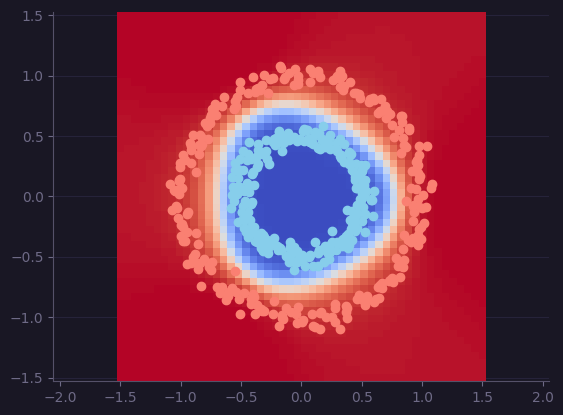

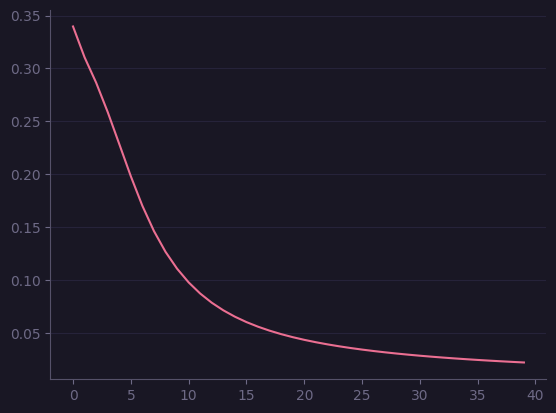

In [18]:
import time 
from IPython.display import clear_output

neural_n = create_nn(topology, tanh)
loss=[]

for i in range (1000):
  #entrenamos a la red
  pY=train(neural_n,X,Y,l2_cost, lr=0.38)
  if i % 25 == 0:
    
    loss.append(l2_cost[0](pY,Y)) #le pasamos la prediccion osea el softmax y el Y real
    res =50
    _x0 = np.linspace(-1.5,1.5,res)
    _x1 = np.linspace(-1.5,1.5,res)
    _Y = np.zeros((res,res))

    for i0,x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):

        _Y[i0,i1]=train(neural_n,np.array([[x0,x1]]),Y,l2_cost, train= False)[0][0]

    plt.pcolormesh(_x0,_x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    plt.scatter(X[Y[:,0]==0, 0],X[Y[:,0]== 0, 1], c="skyblue")
    plt.scatter(X[Y[:,0]==1, 0],X[Y[:,0]== 1, 1], c="salmon")

    clear_output(wait=True)
    plt.show()
    plt.plot(range(len(loss)),loss)
    plt.show()
    time.sleep(0.5)

MNIST
===

importamos los datos del MNIST

In [19]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')
import tensorflow_datasets as tfds
data_dir = 'G:\Doctorado\clases\mineria de datos\Tarea5'

Train data and test data

In [20]:
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

In [21]:
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [22]:
def one_hot(x, k, dtype=jnp.float32):
        """Create a one-hot encoding of x of size k."""
        return jnp.array(x[:, None] == jnp.arange(k), dtype)

Reshape of images to be able to use in MLP

In [23]:
train_images_sin_reshape, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images_sin_reshape, (len(train_images_sin_reshape), num_pixels))
train_labels_sinhot=train_labels
train_labels = one_hot(train_labels, num_labels)
print(train_images.shape)

(60000, 784)


This is what the images look like:

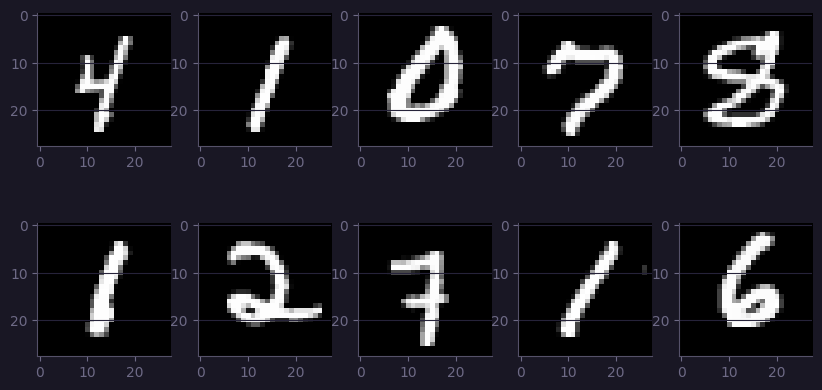

In [24]:
import matplotlib.pyplot as plt
# Seleccionar las primeras 10 imágenes del conjunto de datos de entrenamiento
images = train_images_sin_reshape[:10]
# Crear una figura para trazar las imágenes
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
# Recorrer las imágenes y trazarlas en la figura
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
plt.show()

We train with the classic matrix code and observe metrics:

In [25]:
topology=[784,20,30,20,10]
recalls,precisions,loss,last_prediccion=trainig_model(train_images,train_labels,train_labels_sinhot,topology,l2_cost,steps=2000,lr=0.38,threshold=0.00001)

#### JAX code using automatic differentiation:

In [56]:
class CNN():
    def __init__(self, topology, act_f, key_seed=0): 
        self.topology = topology
        self.act_f = act_f

        nn= [] #es para crear un vector vacio para ir agregando las capas estos son los parametros  W y b 
        for l, layer in enumerate(topology[:- 1]):
            n_conn= topology[l]
            n_neur= topology[l+1]
            ''' Generate random values for b and W using JAX's random module'''
            key = random.PRNGKey(key_seed+l)
            b = random.uniform(key, (1, n_neur), minval=-1.0, maxval=1.0)
            W = random.uniform(key, (n_conn, n_neur), minval=-1.0, maxval=1.0)
            nn.append((W,b))

        self.nn=nn
        
    def forward_jax(self,X:jnp, params)-> jnp:
        out = [X]    
        for w,b in params[:-1]:
            #w=jnp.array(w,dtype=jnp.float32)
            #b=jnp.array(b,dtype=jnp.float32)
            z=jnp.dot(out[-1],w)+b
            a=jnp.tanh(z)
            out.append(a)
        
        w_final,b_final=params[-1]
        logits = jnp.dot(a,w_final) + b_final
        return jax.nn.softmax(logits)
     
    @partial(jax.jit, static_argnums=(0,)) 
    def loss(self,params, X, Y)-> jnp: 
        last_a =self.forward_jax(X,params) 
        loss = -jnp.sum(Y * jnp.log(last_a)) 
        return loss / X.shape[0]
    
    #@partial(jax.jit, static_argnums=(0,))
    def update(self, params, X, Y, lr):
        grads=[]
        gradientes=grad(self.loss)(params, X, Y)
        grads.append(gradientes)
        for l, layer in enumerate(self.nn):
            new_w=self.nn[l][0] -grads[0][l][0]* lr
            new_b=self.nn[l][1] -grads[0][l][1]* lr
            self.nn[l]=(new_w,new_b)

        last_a=self.forward_jax(X, params)
        return last_a

    def train_jax(self,X,Y,lr=0.38):
        self.forward_jax(X,self.nn)
        last_a=self.update(self.nn ,X, Y, lr)
        return last_a
    
    #---------------------------metrics-----------------------------
    @staticmethod
    @jit
    def get_predictions(A2):
        return jnp.argmax(A2,axis=1)

    @staticmethod
    @jit
    def get_accuracy(predictions, Y_sinhot):
        #print(predictions, Y_sinhot)
        return jnp.sum(predictions == Y_sinhot) / Y_sinhot.size

    @staticmethod
    @jit
    def recall_2clases(y_sinhot, y_hat):
        TP=0
        FN=0
        for i in range(len(y_sinhot)):
            if (y_sinhot[i]>0 and y_hat[i]>0):
                TP += 1
            if (y_sinhot[i]<=0 and y_hat[i]>0):
                FN +=1
        recall = (TP/(TP+FN))
        return float(recall)

    @staticmethod
    @jit
    def recall(y_sinhot, y_hat,return_TP_FN=False):
        TP=0
        FN=0
        unique=jnp.unique(y_hat)
        recalls=[]
        for clase in range(len(unique)):
            for muestra in range(len(y_sinhot)):
                if (y_sinhot[muestra]==clase and y_hat[muestra]==clase):
                    TP += 1
                if (y_sinhot[muestra]==clase and y_hat[muestra]!=clase):
                    FN +=1
            recalls.append(TP/(TP+FN))

        mean_recall=jnp.mean(recalls) 
        if return_TP_FN:
            return mean_recall,TP,FN
        else:
            return mean_recall
            
    @staticmethod
    @jit
    def precision(y_sinhot, y_hat,return_TP_FP=False):
        TP=0
        FP=0
        unique=jnp.unique(y_hat)
        precisions=[]
        for clase in range(len(unique)):
            for muestra in range(len(y_sinhot)):
                if (y_sinhot[muestra]==clase and y_hat[muestra]==clase):
                    TP += 1
                if (y_sinhot[muestra]!=clase and y_hat[muestra]==clase):
                    FP +=1
            #para evitar divisiones entre 0
            if (TP+FP)==0:
                precisions.append(0)
            else:
                precisions.append(TP/(TP+FP))
        
        mean_precision=jnp.mean(precisions)
        if return_TP_FP:
            return mean_precision,TP,FP
        else:
            return mean_precision

Code to train using JAX code

In [42]:
def trainig_jax_model(X,Y,Y_sinhot,topology,l2_cost,steps=2000,lr=0.28,threshold=0.000008): #aqui pasara todo foward pass, backward pass y decenso del gradiente lr es el learning reate para el decenso del gradiente
  precisions=[]
  recalls=[]
  loss=[]
  acuracies=[]
  red_neuronal=CNN(topology, tanh)
  for i in range (steps):
    salida_ultima_capa=red_neuronal.train_jax(train_images,train_labels,lr)
    loss.append(red_neuronal.loss(red_neuronal.nn,train_images,train_labels))
    '''print cada 10 pasos para ahorrar tiempo de computo'''
    if i%10==0:
      prediccion=get_predictions(salida_ultima_capa)   
      prediccion=jnp.reshape(prediccion, Y_sinhot.shape)
      acuracies.append(get_accuracy(prediccion,Y_sinhot))
      print('training ------> step=',i,'lost: {:.3f}, acuracy: {:.3f}'.format(loss[-1], acuracies[-1]), end='\r')
      print('training ------> step=',i,'lost: {:.3f}'.format(loss[-1]), end='\r')


    '''print cada 100 pasos para ahorrar tiempo de computo, estas metricas son demasiado costosas'''
    if i%100==0 and i!=0:
      prediccion=get_predictions(salida_ultima_capa)   
      prediccion=jnp.reshape(prediccion, Y_sinhot.shape)
      acuracies.append(get_accuracy(prediccion,Y_sinhot))
      precisions.append(precision(Y_sinhot[:500],prediccion[:500]))
      recalls.append(recall(Y_sinhot[:500],prediccion[:500]))
      #recall_2=recall_2clases(Y_sinhot,prediccion) #esta funcion es para calcular la recall de 2 clases, es para comparar con la recall multiclase
      print('\r' + ' ' * 100, end='\r')
      print('training ------> step=',i,'lost: {:.3f}, acuracy: {:.3f}, recall: {:.3f}, precisions: {:.3f}'.format(loss[-1],acuracies[-1], recalls[-1], precisions[-1]), end='\r')

    #si la perdida no cambia mucho en 2 pasos, se detiene el entrenamiento
    if i>1:
      if jnp.abs(loss[-1]-loss[-2])< threshold:
        '''se realizan los calculos de precision y recall para los primeros 3000 datos (pueden ser mas, pero requiere mas tiempo de computo)'''
        print('\n Stop training, loss not change more than threshold, calculating model metrics...(wait)')
        prediccion=get_predictions(salida_ultima_capa)    
        prediccion=jnp.reshape(prediccion, Y_sinhot.shape)
        acuracies.append(get_accuracy(prediccion,Y_sinhot))
        precisions.append(precision(Y_sinhot[:3000],prediccion[:3000]))
        recalls.append(recall(Y_sinhot[:3000],prediccion[:3000]))
        print('\n -------------------------final metrics-----------------------------')
        print('step=',i,'lost: {:.3f}, acuracy: {:.3f}, recall: {:.3f}, precisions: {:.3f}'.format(loss[-1],acuracies[-1], recalls[-1], precisions[-1]))
        
        break
  return recalls,precisions,loss,prediccion

We make a network with the topology [784,512,512,10] and train:

In [58]:
topology=[784,512,512,10]
recalls,precisions,loss,last_prediccion=trainig_jax_model(train_images,train_labels,train_labels_sinhot,topology,l2_cost,steps=500,lr=0.03,threshold=0.008)

training ------> step= 90 lost: 4.755, acuracy: 0.5355
 Stop training, loss not change more than threshold, calculating model metrics...(wait)

 -------------------------final metrics-----------------------------
step= 97 lost: 4.497, acuracy: 0.551, recall: 0.604, precisions: 0.609


Observamos metricas durante el entrenamiento y confusión matrix:

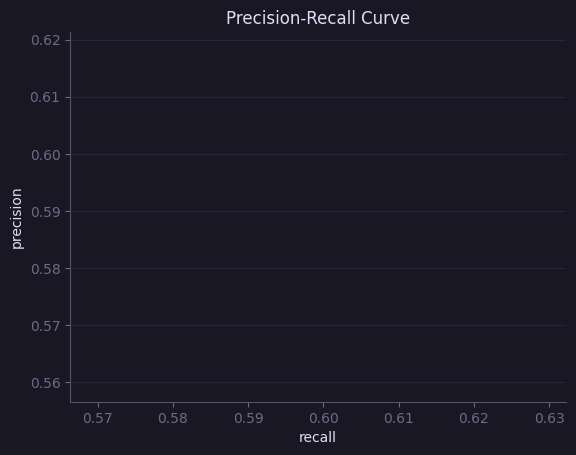

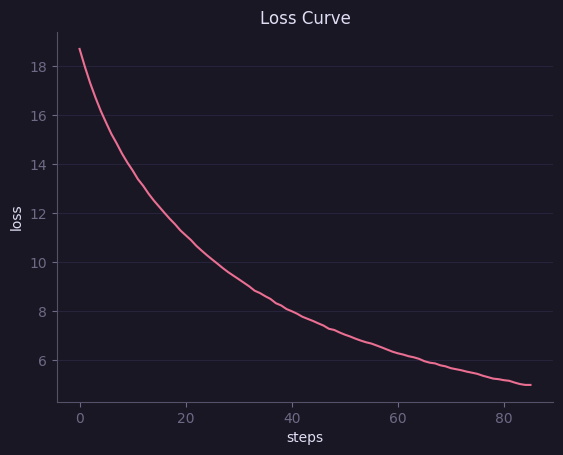

(500, 1)
(60000,)


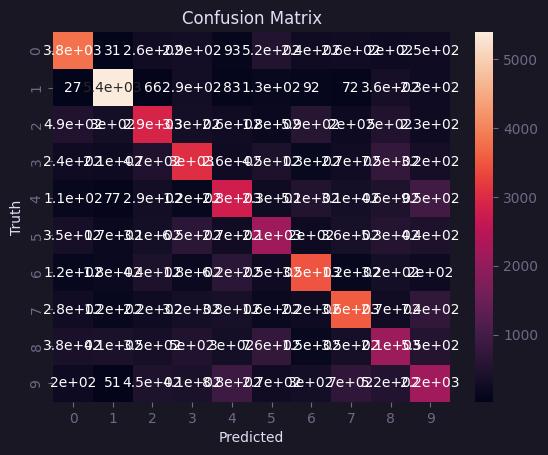

In [29]:
precision_recall_plot(recalls,precisions)
loss_plot(loss)
print(Y_sinhot.shape),print(last_prediccion.shape)
confusion_matrix_plot(train_labels_sinhot, last_prediccion)

#### Multi-Layer Perceptron as Convolutional Kernel


We do a test of taking the images, reshaping and dividing them into 4X4 squares and reshaping the image. This in order to recover the image after applying 'kernel' in MLP

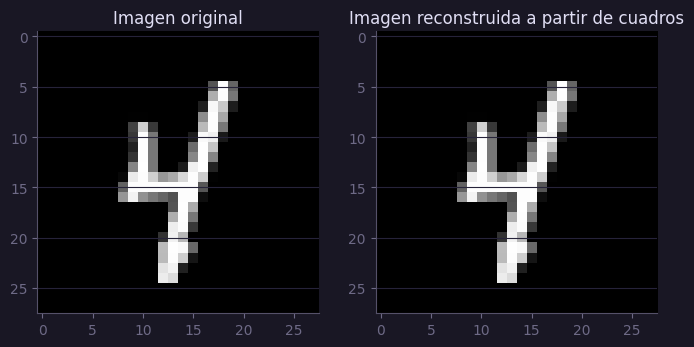

In [30]:
conv_train_images=jnp.reshape(train_images_sin_reshape,(train_images_sin_reshape.shape[0],28,28))
conv_train_images=jnp.reshape(train_images_sin_reshape,(train_images_sin_reshape.shape[0],49,4,4))

image=train_images_sin_reshape[0]
squares=conv_train_images[0]

# Reorganizar los cuadros en el orden correcto
squares_reordered = np.zeros_like(squares)
for i in range(49):
    row, col = np.unravel_index(i, (7, 7))
    squares_reordered[row*7+col] = squares[i]

# Reconstruir la imagen original a partir de los cuadros
reconstructed_image = np.reshape(squares_reordered, (28, 28))

# Mostrar la imagen original y los cuadros
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Imagen original')
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title('Imagen reconstruida a partir de cuadros')
plt.show()

filter 1 - we apply an MLP as a kind of 'kernel' to the images

In [31]:
topology_conv=[16,1,16]
red_neuronal_conv_1=CNN(topology_conv, tanh)
params=red_neuronal_conv_1.nn
new_images_conv1=[]
for i in range (conv_train_images.shape[0]):
#for i in range (15):
    image_i=conv_train_images[i,:,:,:]
    image_i=jnp.reshape(image_i,(49,16))
    out_image=red_neuronal_conv_1.forward_jax(image_i,params)
    new_images_conv1.append(out_image)

new_images_conv1=jnp.array(new_images_conv1)
new_images_conv1.shape
new_images_conv1=jnp.reshape(new_images_conv1,(conv_train_images.shape[0],49,4,4))
    

We plot reconstructed images after MLP

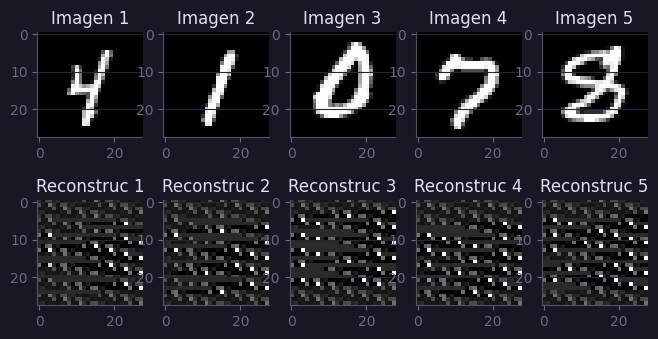

In [32]:
def plot_images(new_images_conv, train_images_sin_reshape, n=5):
    fig = plt.figure(figsize=(16, 4))
    for i in range(n):
        # Obtener la imagen original y los cuadros reconstruidos
        image = train_images_sin_reshape[i]
        squares = new_images_conv[i]

        # Reorganizar los cuadros en el orden correcto
        squares_reordered = np.zeros_like(squares)
        for j in range(49):
            row, col = np.unravel_index(j, (7, 7))
            squares_reordered[row*7+col] = squares[j]

        # Reconstruir la imagen original a partir de los cuadros
        reconstructed_image = jnp.reshape(squares_reordered, (28, 28))

        # Crear un nuevo subplot y mostrar la imagen original y la reconstruida
        ax = fig.add_subplot(2, 10, i+1)
        ax.imshow(image, cmap='gray')
        ax.set_title('Imagen {}'.format(i+1))

        ax = fig.add_subplot(2, 10, i+11)
        ax.imshow(reconstructed_image, cmap='gray')
        ax.set_title('Reconstruc {}'.format(i+1))

    plt.show()

plot_images(new_images_conv1, train_images_sin_reshape, n=5)


We make a prediction after a filter and look at metrics:

In [33]:
train_images_after_conv = jnp.reshape(new_images_conv1, (len(new_images_conv1), num_pixels))
topology=[784,512,512,10]
recalls,precisions,loss,last_prediccion=trainig_jax_model(train_images_after_conv,train_labels,train_labels_sinhot,topology,l2_cost,steps=500,lr=0.03,threshold=0.00008)

training ------> step= 270 lost: 2.108, acuracy: 0.744, recall: 0.749, precisions: 0.712            
 Stop training, loss not change more than threshold, calculating model metrics...(wait)

 -------------------------final metrics-----------------------------
step= 271 lost: 2.108, acuracy: 0.744, recall: 0.787, precisions: 0.784


Let's see the metrics:

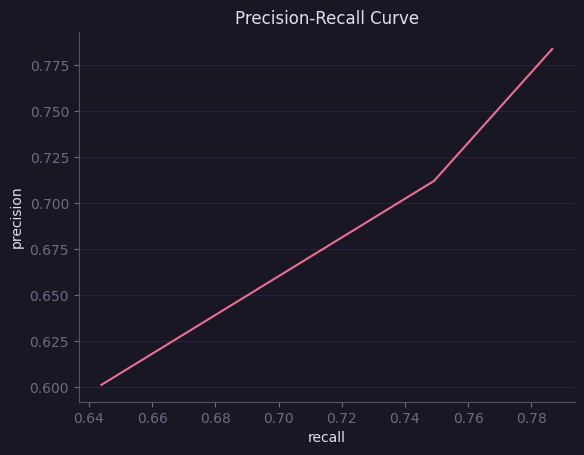

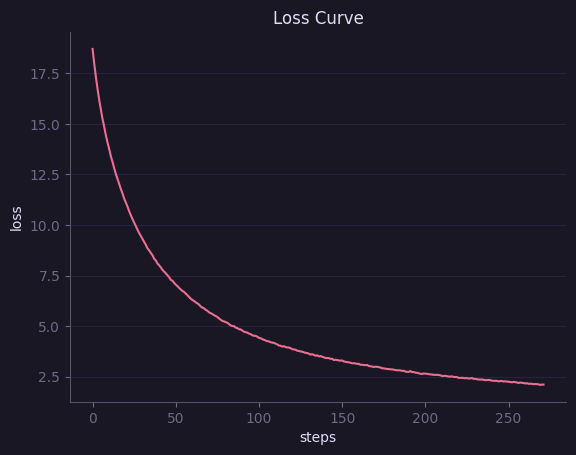

(500, 1)
(60000,)


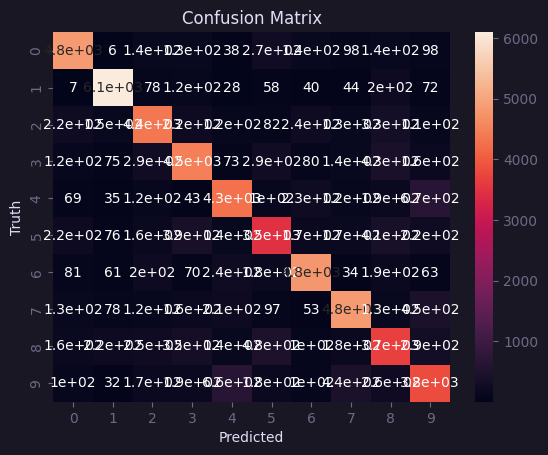

In [34]:
precision_recall_plot(recalls,precisions)
loss_plot(loss)
print(Y_sinhot.shape),print(last_prediccion.shape)
confusion_matrix_plot(train_labels_sinhot, last_prediccion)

filter 2 - the output of the first MLP is passed through another MLP simulating another convolution and we observe output images:

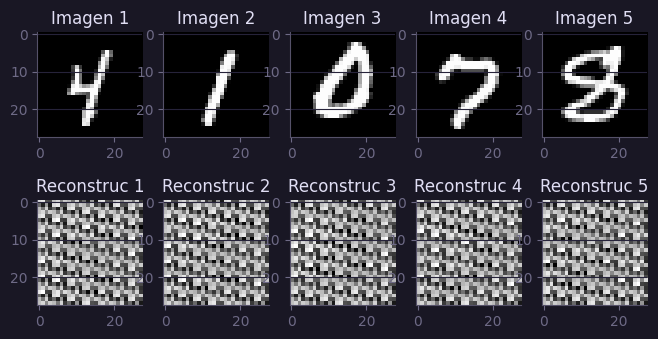

In [35]:
topology_conv=[16,1,16]
red_neuronal_conv_2=CNN(topology_conv, tanh, key_seed=100)
params=red_neuronal_conv_2.nn
new_images_conv2=[]
for i in range (conv_train_images.shape[0]):
    image_i=new_images_conv1[i,:,:,:]
    image_i=jnp.reshape(image_i,(49,16))
    out_image=red_neuronal_conv_2.forward_jax(image_i,params)
    new_images_conv2.append(out_image)

new_images_conv2=jnp.array(new_images_conv2)
new_images_conv2.shape
new_images_conv2=jnp.reshape(new_images_conv2,(conv_train_images.shape[0],49,4,4))

plot_images(new_images_conv2, train_images_sin_reshape, n=5)

We make a prediction after the 2nd convolution and see metrics to compare with the previous one:

training ------> step= 270 lost: 2.108, acuracy: 0.744, recall: 0.749, precisions: 0.712            
 Stop training, loss not change more than threshold, calculating model metrics...(wait)

 -------------------------final metrics-----------------------------
step= 271 lost: 2.108, acuracy: 0.744, recall: 0.787, precisions: 0.784


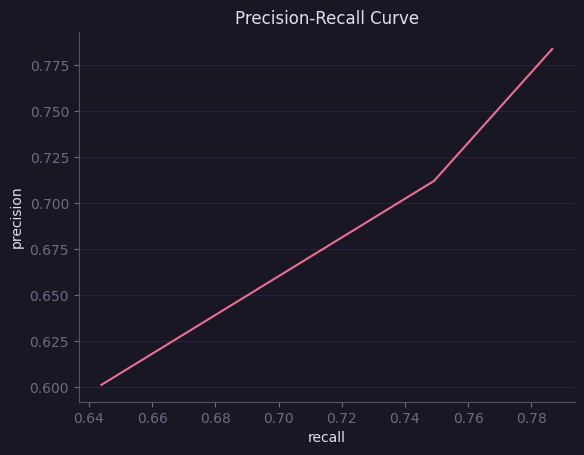

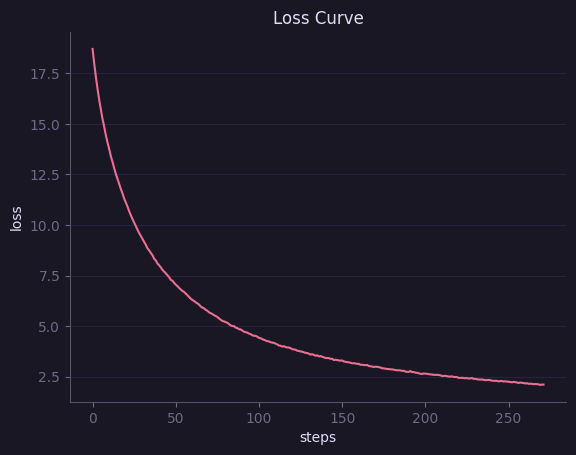

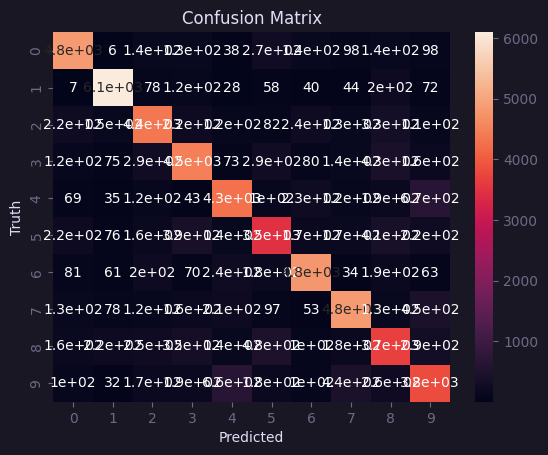

In [36]:
train_images_after_conv_2 = jnp.reshape(new_images_conv1, (len(new_images_conv1), num_pixels))
topology=[784,512,512,10]
recalls,precisions,loss,last_prediccion=trainig_jax_model(train_images_after_conv,train_labels,train_labels_sinhot,topology,l2_cost,steps=500,lr=0.03,threshold=0.00008)

precision_recall_plot(recalls,precisions)
loss_plot(loss)
confusion_matrix_plot(train_labels_sinhot, last_prediccion)

In general, a considerable improvement was not observed by applying this 'kernels' method.